IMPORTING REQUIREMENTS

In [4]:
import boto3
import sagemaker
import pandas as pd
import os
from sagemaker.inputs import TrainingInput
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from scipy.stats import skew
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import GradientBoostingRegressor, VotingRegressor
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
import sklearn
import joblib
!pip install holidays xgboost lightgbm
import holidays
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sagemaker.sklearn.model import SKLearnModel
import json

CREATING AN S3 BUCKET

In [5]:
bucket_name = 'salesforecastingbucket9321423572'
my_region = boto3.session.Session().region_name
print(my_region)

us-east-1


In [6]:
s3 = boto3.resource('s3')
try:
    if my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    print('S3 Bucket created successfully')
except Exception as e:
    print('S3 error: ', e)

S3 Bucket created successfully


In [7]:
prefix = 'salesforecast'
output_path = 's3://{}/{}/output'.format(bucket_name,prefix)
print(output_path)

s3://salesforecastingbucket9321423572/salesforecast/output


UPLOADING THE DATASET TO THE S3 BUCKET AND LOADING IT IN THE DF

In [8]:
# boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')

In [9]:
df = pd.read_csv(f's3://{bucket_name}/{prefix}/train/train.csv')

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:298: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [10]:
print(df.head())

   Row ID        Order ID  Order Date   Ship Date       Ship Mode Customer ID  \
0       1  CA-2017-152156   8/11/2017  11/11/2017    Second Class    CG-12520   
1       2  CA-2017-152156   8/11/2017  11/11/2017    Second Class    CG-12520   
2       3  CA-2017-138688   12/6/2017  16/06/2017    Second Class    DV-13045   
3       4  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   
4       5  US-2016-108966  11/10/2016  18/10/2016  Standard Class    SO-20335   

     Customer Name    Segment        Country             City       State  \
0      Claire Gute   Consumer  United States        Henderson    Kentucky   
1      Claire Gute   Consumer  United States        Henderson    Kentucky   
2  Darrin Van Huff  Corporate  United States      Los Angeles  California   
3   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   
4   Sean O'Donnell   Consumer  United States  Fort Lauderdale     Florida   

   Postal Code Region       Product ID         Cat

DATA PREPROCESSING STEPS:

In [11]:
state_map = {
    "Alabama": "AL", "Alaska": "AK", "Arizona": "AZ", "Arkansas": "AR",
    "California": "CA", "Colorado": "CO", "Connecticut": "CT", "Delaware": "DE",
    "Florida": "FL", "Georgia": "GA", "Hawaii": "HI", "Idaho": "ID",
    "Illinois": "IL", "Indiana": "IN", "Iowa": "IA", "Kansas": "KS",
    "Kentucky": "KY", "Louisiana": "LA", "Maine": "ME", "Maryland": "MD",
    "Massachusetts": "MA", "Michigan": "MI", "Minnesota": "MN", "Mississippi": "MS",
    "Missouri": "MO", "Montana": "MT", "Nebraska": "NE", "Nevada": "NV",
    "New Hampshire": "NH", "New Jersey": "NJ", "New Mexico": "NM", "New York": "NY",
    "North Carolina": "NC", "North Dakota": "ND", "Ohio": "OH", "Oklahoma": "OK",
    "Oregon": "OR", "Pennsylvania": "PA", "Rhode Island": "RI", "South Carolina": "SC",
    "South Dakota": "SD", "Tennessee": "TN", "Texas": "TX", "Utah": "UT",
    "Vermont": "VT", "Virginia": "VA", "Washington": "WA", "West Virginia": "WV",
    "Wisconsin": "WI", "Wyoming": "WY", "District of Columbia": "DC"
}

In [12]:
df['Order Date'] = pd.to_datetime(df['Order Date'], dayfirst=True, errors='coerce')

MARKING NATIONAL AND STATE HOLIDAYS

In [13]:
df["State"] = df["State"].map(state_map).fillna(df["State"])

# --- Add is_weekend column ---
df["is_weekend"] = df["Order Date"].dt.dayofweek >= 5   # Saturday=5, Sunday=6

# --- Add is_holiday column ---
def is_us_holiday(date, state_code):
    if pd.isna(date):
        return False
    try:
        state_holidays = holidays.US(years=[date.year], state=state_code)
    except:
        state_holidays = holidays.US(years=[date.year])  # fallback federal only
    return date in state_holidays

df["is_holiday"] = df.apply(lambda row: is_us_holiday(row["Order Date"], row["State"]), axis=1)

In [14]:
df['log_sales'] = np.log1p(df['Sales'])
df.drop(columns=['Sales'], inplace=True)

In [15]:
def enhanced_time_features(df, date_column):
    """Add comprehensive time-based features"""
    df = df.copy()
    df['year'] = df[date_column].dt.year
    df['month'] = df[date_column].dt.month
    df['quarter'] = df[date_column].dt.quarter
    df['week_of_year'] = df[date_column].dt.isocalendar().week
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['day_of_month'] = df[date_column].dt.day
    df['is_month_start'] = df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    
    # Cyclical encoding for periodic features
    df['month_sin'] = np.sin(2 * np.pi * df['month']/12)
    df['month_cos'] = np.cos(2 * np.pi * df['month']/12)
    df['day_of_week_sin'] = np.sin(2 * np.pi * df['day_of_week']/7)
    df['day_of_week_cos'] = np.cos(2 * np.pi * df['day_of_week']/7)
    
    return df

df = enhanced_time_features(df, 'Order Date')

ENCODING THE COLUMN VALUES

In [16]:
label_encoders = {}
categorical_cols = ['Ship Mode', 'Segment', 'City', 'State', 'Category', 'Sub-Category', 'Region']

for col in categorical_cols:
    le = LabelEncoder()
    df[col] = df[col].fillna('Unknown').astype(str)
    df[col + '_encoded'] = le.fit_transform(df[col])
    label_encoders[col] = le
    print(f"Encoded {col} with {len(le.classes_)} unique values")

Encoded Ship Mode with 4 unique values
Encoded Segment with 3 unique values
Encoded City with 529 unique values
Encoded State with 49 unique values
Encoded Category with 3 unique values
Encoded Sub-Category with 17 unique values
Encoded Region with 4 unique values


DEFINING THE FEATURE AND TARGET COLUMNS

In [17]:
feature_columns = [
    'year', 'month', 'quarter', 'week_of_year', 'day_of_week', 
    'day_of_month', 'is_month_start', 'is_month_end',
    'month_sin', 'month_cos', 'day_of_week_sin', 'day_of_week_cos',
    'is_weekend', 'is_holiday',
    'Ship Mode_encoded', 'Segment_encoded', 'City_encoded', 
    'State_encoded', 'Category_encoded', 'Sub-Category_encoded', 'Region_encoded'
]

target_column = 'log_sales'

Creating monthly aggregated data with proper holiday/weekend features

In [18]:
print("\nCreating monthly aggregated data with proper holiday/weekend features...")

# First, calculate monthly counts of weekends and holidays
monthly_counts = df.groupby([pd.Grouper(key='Order Date', freq='ME'), 
                           'Region_encoded', 'Category_encoded']).agg({
    'log_sales': 'mean',
    'is_weekend': 'sum',      # Total weekend days in month
    'is_holiday': 'sum',      # Total holiday days in month
    'Ship Mode_encoded': 'first',
    'Segment_encoded': 'first',
    'State_encoded': 'first',
    'Sub-Category_encoded': 'first',
    'City_encoded': 'first'  # Keep City_encoded for target encoding
}).reset_index()

# Rename the count columns
monthly_counts = monthly_counts.rename(columns={
    'is_weekend': 'total_weekends',
    'is_holiday': 'total_holidays'
})


Creating monthly aggregated data with proper holiday/weekend features...


In [19]:
monthly_data = enhanced_time_features(monthly_counts, 'Order Date')

# Add proportion features (more meaningful than counts)
monthly_data['weekend_proportion'] = monthly_data['total_weekends'] / 8  # Approx max weekends per month
monthly_data['holiday_proportion'] = monthly_data['total_holidays'] / 3  # Approx max holidays per month

ROLLING STATISTICS AND GROWTH FEATURES

In [20]:
print("Adding advanced features...")

def add_advanced_features(df):
    """Add rolling statistics and growth features"""
    df = df.copy()
    
    # Sort by date for rolling calculations
    df = df.sort_values(['Region_encoded', 'Category_encoded', 'Order Date'])
    
    # Rolling statistics (3, 6, 12 month windows)
    for window in [3, 6, 12]:
        df[f'rolling_mean_{window}'] = df.groupby(['Region_encoded', 'Category_encoded'])['log_sales'].transform(
            lambda x: x.rolling(window, min_periods=1).mean()
        )
        df[f'rolling_std_{window}'] = df.groupby(['Region_encoded', 'Category_encoded'])['log_sales'].transform(
            lambda x: x.rolling(window, min_periods=1).std()
        )
    
    # Year-over-year growth rates
    df['yoy_growth'] = df.groupby(['Region_encoded', 'Category_encoded'])['log_sales'].pct_change(12)
    
    # Month-over-month growth
    df['mom_growth'] = df.groupby(['Region_encoded', 'Category_encoded'])['log_sales'].pct_change(1)
    
    return df

monthly_data = add_advanced_features(monthly_data)

Adding advanced features...


ENCODING FOR HIGH CARDINALITY FEATURES

In [21]:
print("Applying manual target encoding for high-cardinality features...")

def manual_target_encoding(df, group_col, target_col, new_col_name):
    """Manual target encoding implementation"""
    # Calculate mean target by group
    group_means = df.groupby(group_col)[target_col].mean().to_dict()
    # Apply encoding
    df[new_col_name] = df[group_col].map(group_means)
    # Fill any NaN values with overall mean
    overall_mean = df[target_col].mean()
    df[new_col_name] = df[new_col_name].fillna(overall_mean)
    return df

# Apply target encoding to high-cardinality features
monthly_data = manual_target_encoding(monthly_data, 'City_encoded', 'log_sales', 'city_target_encoded')
monthly_data = manual_target_encoding(monthly_data, 'State_encoded', 'log_sales', 'state_target_encoded')

Applying manual target encoding for high-cardinality features...


In [22]:
monthly_data = monthly_data.drop(columns=['City_encoded', 'State_encoded'])

print(f"Monthly data shape: {monthly_data.shape}")

Monthly data shape: (573, 33)


ADDING LAG FEATURES

In [23]:
def add_lag_features(df, target_col, lags=[1, 2, 3, 6, 12]):
    """Add lagged target values as features"""
    df = df.copy()
    df = df.sort_values('Order Date').reset_index(drop=True)
    
    group_cols = ['Region_encoded', 'Category_encoded']
    
    for lag in lags:
        lag_col = f'{target_col}_lag_{lag}'
        df[lag_col] = df.groupby(group_cols)[target_col].shift(lag)
    
    return df

monthly_data_with_lags = add_lag_features(monthly_data, 'log_sales')
monthly_data_with_lags = monthly_data_with_lags.dropna()

In [24]:
# Update feature list with new features
lag_features = [col for col in monthly_data_with_lags.columns if 'lag_' in col]
rolling_features = [col for col in monthly_data_with_lags.columns if 'rolling_' in col]
growth_features = [col for col in monthly_data_with_lags.columns if 'growth' in col]
target_encoded_features = [col for col in monthly_data_with_lags.columns if 'target_encoded' in col]

updated_features = [col for col in feature_columns if col in monthly_data_with_lags.columns] + \
                  ['total_weekends', 'total_holidays', 'weekend_proportion', 'holiday_proportion'] + \
                  lag_features + rolling_features + growth_features + target_encoded_features

# Remove any duplicate or unnecessary features
updated_features = [col for col in updated_features if col in monthly_data_with_lags.columns]
updated_features = list(set(updated_features))  # Remove duplicates

print(f"Total features after enhancement: {len(updated_features)}")

Total features after enhancement: 36


TRAIN TEST SPLIT

In [25]:
def prepare_time_series_data(data, features, target, test_size=0.2):
    """Prepare time series data with proper temporal splitting"""
    data = data.sort_values('Order Date').dropna()
    
    split_idx = int(len(data) * (1 - test_size))
    
    X = data[features]
    y = data[target]
    
    X_train, X_test = X.iloc[:split_idx], X.iloc[split_idx:]
    y_train, y_test = y.iloc[:split_idx], y.iloc[split_idx:]
    
    print(f"Train size: {len(X_train)}, Test size: {len(X_test)}")
    print(f"Train period: {data['Order Date'].iloc[0]} to {data['Order Date'].iloc[split_idx-1]}")
    print(f"Test period: {data['Order Date'].iloc[split_idx]} to {data['Order Date'].iloc[-1]}")
    
    return X_train, X_test, y_train, y_test

# Prepare monthly data
X_train_monthly, X_test_monthly, y_train_monthly, y_test_monthly = prepare_time_series_data(
    monthly_data_with_lags, updated_features, target_column
)

Train size: 343, Test size: 86
Train period: 2016-01-31 00:00:00 to 2018-05-31 00:00:00
Test period: 2018-05-31 00:00:00 to 2018-12-31 00:00:00


DEFINING ML MODELS

In [26]:
print("\nTraining ensemble model...")

# Create individual models with optimized parameters
gb_model = GradientBoostingRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    min_samples_split=5,
    random_state=42
)

xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    verbosity=0
)

lgbm_model = LGBMRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=4,
    random_state=42,
    verbose=-1
)


Training ensemble model...


In [27]:
print("Training individual models...")
models = {
    'Gradient Boosting': gb_model,
    'XGBoost': xgb_model,
    'LightGBM': lgbm_model
}

Training individual models...


In [28]:
individual_results = {}
for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train_monthly, y_train_monthly)
    
    # Predict and evaluate
    preds_log = model.predict(X_test_monthly)
    preds = np.expm1(preds_log)
    actuals = np.expm1(y_test_monthly)
    
    mae = mean_absolute_error(actuals, preds)
    mape = np.mean(np.abs((actuals - preds) / actuals)) * 100
    
    individual_results[name] = {'MAE': mae, 'MAPE': mape}
    print(f"{name}: MAE = ${mae:.2f}, MAPE = {mape:.2f}%")

Training Gradient Boosting...
Gradient Boosting: MAE = $8.67, MAPE = 7.57%
Training XGBoost...
XGBoost: MAE = $8.76, MAPE = 8.16%
Training LightGBM...
LightGBM: MAE = $7.54, MAPE = 7.43%


TRAINING ENSEMBLE MODEL

In [29]:
print("\nTraining ensemble model...")
ensemble_model = VotingRegressor(
    estimators=[
        ('gb', gb_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model)
    ]
)
ensemble_model.fit(X_train_monthly, y_train_monthly)


Training ensemble model...


,estimators,"[('gb', ...), ('xgb', ...), ...]"
,weights,None
,n_jobs,None
,verbose,False
,loss,'squared_error'
,learning_rate,0.1
,n_estimators,100
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,5
,min_samples_leaf,1


ACCURACY SCORES (MAE, RMSE, MAPE)

In [30]:
ensemble_preds_log = ensemble_model.predict(X_test_monthly)
ensemble_preds = np.expm1(ensemble_preds_log)
ensemble_actuals = np.expm1(y_test_monthly)

ensemble_mae = mean_absolute_error(ensemble_actuals, ensemble_preds)
ensemble_rmse = np.sqrt(mean_squared_error(ensemble_actuals, ensemble_preds))
ensemble_mape = np.mean(np.abs((ensemble_actuals - ensemble_preds) / ensemble_actuals)) * 100

In [31]:
print(f"\n{'='*60}")
print("ENSEMBLE MODEL PERFORMANCE")
print(f"{'='*60}")
print(f"MAE: ${ensemble_mae:,.2f}")
print(f"RMSE: ${ensemble_rmse:,.2f}")
print(f"MAPE: {ensemble_mape:.2f}%")


ENSEMBLE MODEL PERFORMANCE
MAE: $7.79
RMSE: $12.39
MAPE: 7.12%


MODEL COMPARISON

In [32]:
print(f"\n{'='*60}")
print("MODEL COMPARISON")
print(f"{'='*60}")
for name, results in individual_results.items():
    print(f"{name:20} | MAE: ${results['MAE']:,.2f} | MAPE: {results['MAPE']:.2f}%")

print(f"{'Ensemble':20} | MAE: ${ensemble_mae:,.2f} | MAPE: {ensemble_mape:.2f}%")


MODEL COMPARISON
Gradient Boosting    | MAE: $8.67 | MAPE: 7.57%
XGBoost              | MAE: $8.76 | MAPE: 8.16%
LightGBM             | MAE: $7.54 | MAPE: 7.43%
Ensemble             | MAE: $7.79 | MAPE: 7.12%


RESIDUAL ANALYSIS AND CORRECTION

In [33]:
print(f"\n{'='*60}")
print("RESIDUAL ANALYSIS AND CORRECTION")
print(f"{'='*60}")

# Calculate residuals
train_residuals = y_train_monthly - ensemble_model.predict(X_train_monthly)

# Train residual correction model
residual_model = GradientBoostingRegressor(
    n_estimators=50,
    learning_rate=0.1,
    max_depth=3,
    random_state=42
)
residual_model.fit(X_train_monthly, train_residuals)


RESIDUAL ANALYSIS AND CORRECTION


,loss,'squared_error'
,learning_rate,0.1
,n_estimators,50
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,3
,min_impurity_decrease,0.0
,init,None


In [34]:
corrected_preds_log = ensemble_preds_log + residual_model.predict(X_test_monthly)
corrected_preds = np.expm1(corrected_preds_log)

corrected_mae = mean_absolute_error(ensemble_actuals, corrected_preds)
corrected_rmse = np.sqrt(mean_squared_error(ensemble_actuals, corrected_preds))
corrected_mape = np.mean(np.abs((ensemble_actuals - corrected_preds) / ensemble_actuals)) * 100

In [35]:
print(f"After residual correction:")
print(f"MAE: ${corrected_mae:,.2f} (Improvement: {((ensemble_mae - corrected_mae)/ensemble_mae*100):.1f}%)")
print(f"MAPE: {corrected_mape:.2f}% (Improvement: {((ensemble_mape - corrected_mape)/ensemble_mape*100):.1f}%)")

After residual correction:
MAE: $7.77 (Improvement: 0.2%)
MAPE: 7.04% (Improvement: 1.1%)


FINAL OPTIMIZED PERFORMANCE

In [36]:
print(f"\n{'='*60}")
print("FINAL OPTIMIZED PERFORMANCE")
print(f"{'='*60}")
print(f"MAE: ${corrected_mae:,.2f}")
print(f"RMSE: ${corrected_rmse:,.2f}")
print(f"MAPE: {corrected_mape:.2f}%")


FINAL OPTIMIZED PERFORMANCE
MAE: $7.77
RMSE: $12.38
MAPE: 7.04%


IMPORTANT FEATURES VISUALIZATION

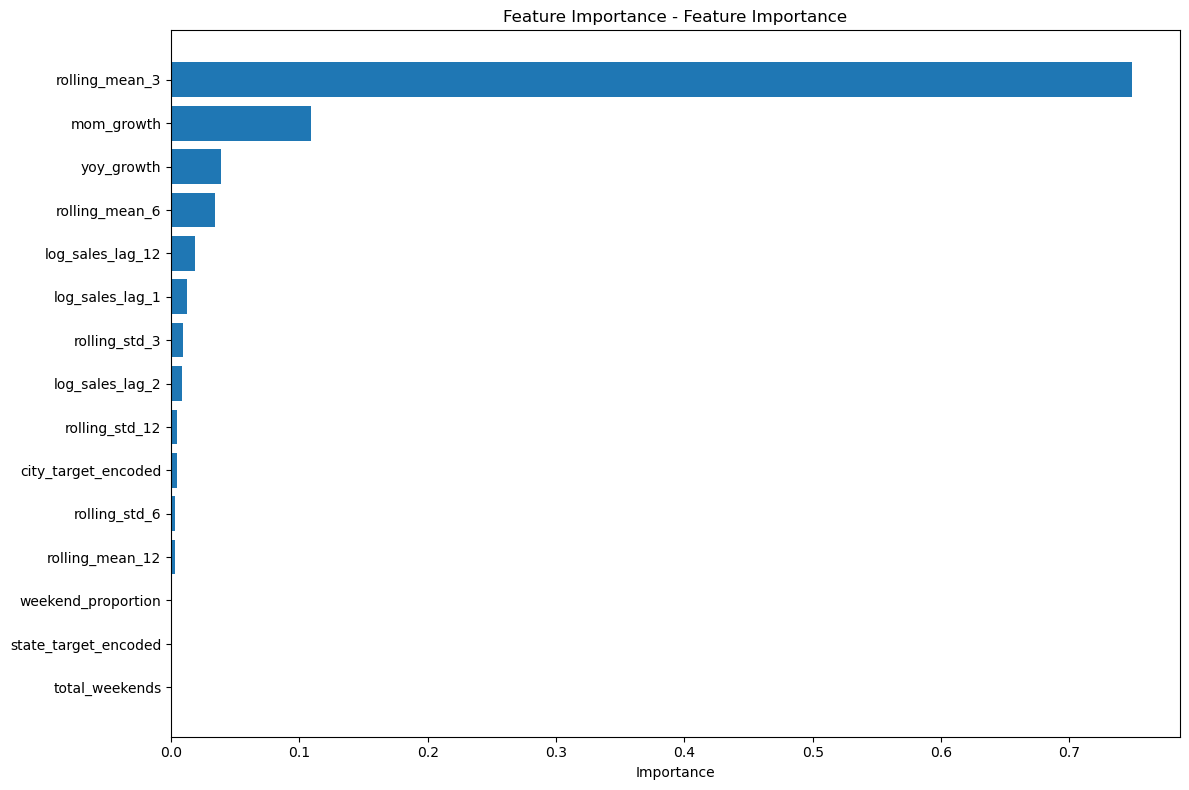

In [37]:
def plot_feature_importance(model, feature_names, title):
    if hasattr(model, 'feature_importances_'):
        importance = model.feature_importances_
        indices = np.argsort(importance)[::-1]
        
        plt.figure(figsize=(12, 8))
        plt.title(f"Feature Importance - {title}")
        plt.barh(range(15), importance[indices][:15][::-1])
        plt.yticks(range(15), [feature_names[i] for i in indices[:15]][::-1])
        plt.xlabel('Importance')
        plt.tight_layout()
        plt.show()
        return indices
    return None

# Plot feature importance for the ensemble's best model
feature_indices = plot_feature_importance(gb_model, updated_features, "Feature Importance")

IMPORTANT FEATURES

In [38]:
if feature_indices is not None:
    print("\nTop 10 most important features:")
    for i in range(10):
        feature_name = updated_features[feature_indices[i]]
        importance = gb_model.feature_importances_[feature_indices[i]]
        print(f"  {i+1}. {feature_name}: {importance:.4f}")


Top 10 most important features:
  1. rolling_mean_3: 0.7487
  2. mom_growth: 0.1094
  3. yoy_growth: 0.0392
  4. rolling_mean_6: 0.0340
  5. log_sales_lag_12: 0.0187
  6. log_sales_lag_1: 0.0126
  7. rolling_std_3: 0.0096
  8. log_sales_lag_2: 0.0089
  9. rolling_std_12: 0.0047
  10. city_target_encoded: 0.0045


SAVING THE FINAL MODEL

In [39]:
final_model = {
    'ensemble': ensemble_model,
    'residual_correction': residual_model,
    'feature_names': updated_features,
    'label_encoders': label_encoders
}
joblib.dump(final_model, "model.joblib")

['model.joblib']

In [40]:
!tar -czvf model.tar.gz model.joblib

model.joblib


UPLOADING THE MODEL TO S3 BUCKET

In [41]:
s3 = boto3.client("s3")
bucket = "salesforecastingbucket9321423572"
s3.upload_file("model.tar.gz", bucket, "models/model.tar.gz")

# 4. Get final S3 path
model_artifact = f"s3://{bucket}/models/model.tar.gz"
print("Uploaded model to:", model_artifact)

Uploaded model to: s3://salesforecastingbucket9321423572/models/model.tar.gz


Production prediction function with residual correction

In [42]:
def predict_sales(features_df):
    """Production prediction function with residual correction"""
    # Ensemble prediction
    ensemble_pred = final_model['ensemble'].predict(features_df)
    # Residual correction
    residual_pred = final_model['residual_correction'].predict(features_df)
    # Final prediction
    final_pred_log = ensemble_pred + residual_pred
    return np.expm1(final_pred_log)

In [43]:
test_predictions = predict_sales(X_test_monthly.iloc[:5])
print(f"\nSample predictions: {test_predictions}")
print(f"Actual values: {ensemble_actuals.iloc[:5].values}")


Sample predictions: [ 43.6575227   40.50104252  44.517548   144.22810669  39.5162495 ]
Actual values: [ 37.50468081  37.17377061  42.78889716 144.04494369  39.06844444]


In [44]:
!ls -la /home/ec2-user/SageMaker/

total 1568
drwxr-xr-x  9 ec2-user ec2-user    4096 Sep  6 21:23 .
drwx------ 23 ec2-user ec2-user    4096 Sep  6 20:45 ..
drwxr-xr-x  2 root     root        4096 Aug 24 16:42 code
-rw-rw-r--  1 ec2-user ec2-user     704 Aug 24 16:54 Dockerfile
-rw-rw-r--  1 ec2-user ec2-user    4461 Aug 24 17:54 inference.py
drwxrwxr-x  2 ec2-user ec2-user    4096 Aug 24 19:38 .ipynb_checkpoints
drwx------  2 root     root       16384 Aug 22 19:26 lost+found
-rw-rw-r--  1 ec2-user ec2-user 1010725 Sep  6 21:25 model.joblib
-rw-rw-r--  1 ec2-user ec2-user  287208 Sep  6 21:25 model.tar.gz
-rw-rw-r--  1 ec2-user ec2-user     180 Aug 24 17:10 requirements.txt
-rw-rw-r--  1 ec2-user ec2-user  226193 Sep  6 21:23 SalesForecast.ipynb
drwxr-xr-x  2 ec2-user ec2-user    4096 Aug 22 19:26 .sparkmagic
-rw-rw-r--  1 ec2-user ec2-user    6445 Aug 24 19:56 testing.ipynb
drwxr-xr-x  2 root     root        4096 Aug 24 16:47 test-model
drwx------  4 ec2-user ec2-user    4096 Aug 23 18:00 .Trash-1000
drwxrwxr-x  2 ec2-

BUILDING THE DOCKER IMAGE

In [45]:
!cd /home/ec2-user/SageMaker && docker build -t sklearn-170-custom .

[+] Building 0.0s (0/0)  docker:default
[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.2s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.1s
 => => transferring dockerfile: 743B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.10-slim        0.2s
[+] Building 0.4s (1/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.1s
 => => transferring dockerfile: 743B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.10-slim        0.3s
[+] Building 0.4s (2/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.1s
 => => transferring dockerfile: 743B                                       0.0s


PUSHING THE DOCKER IMAGE TO ECR

In [46]:
import boto3
from sagemaker.model import Model
import sagemaker
from sagemaker import get_execution_role

# Initialize
session = sagemaker.Session()
role = get_execution_role()
region = boto3.session.Session().region_name
account_id = boto3.client('sts').get_caller_identity()['Account']

# Login to ECR
!aws ecr get-login-password --region {region} | docker login --username AWS --password-stdin {account_id}.dkr.ecr.{region}.amazonaws.com

# Create ECR repository (if it doesn't exist)
!aws ecr create-repository --repository-name sklearn-170-custom --region {region} || echo "Repository already exists"

# Tag the Docker image for ECR
!docker tag sklearn-170-custom:latest {account_id}.dkr.ecr.{region}.amazonaws.com/sklearn-170-custom:latest

# Push the image to ECR
!docker push {account_id}.dkr.ecr.{region}.amazonaws.com/sklearn-170-custom:latest

print("✅ Docker image pushed to ECR successfully!")

WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded

An error occurred (RepositoryAlreadyExistsException) when calling the CreateRepository operation: The repository with name 'sklearn-170-custom' already exists in the registry with id '741448958395'
Repository already exists
The push refers to repository [741448958395.dkr.ecr.us-east-1.amazonaws.com/sklearn-170-custom]

74414e5a: Preparing 
7184ec15: Preparing 
bf18a086: Preparing 
7d85b456: Preparing 
628f96fa: Preparing 
a324e025: Preparing 
0c91039b: Preparing 
c6abdbc9: Preparing 
c16a5636: Preparing 
d8a8f58c: Preparing 
latest: digest: sha256:14f02ea92ef533d2a5e319f91123ee3dd02fd47130354c14098f58f4668c8759 size: 2622
✅ Docker image pushed to ECR successfully!


CREATING AN AWS ENDPOINT

In [47]:
import time
from sagemaker.model import Model

# Your model artifact S3 path (replace with your actual path)
model_artifact = model_artifact

# Use custom container image
image_uri = f"{account_id}.dkr.ecr.{region}.amazonaws.com/sklearn-170-custom:latest"

# Generate unique timestamp for names
timestamp = int(time.time())
unique_model_name = f"sklearn-170-custom-model-{timestamp}"
unique_endpoint_name = f"sklearn-170-custom-endpoint-{timestamp}"

# Create model with custom container
custom_model = Model(
    image_uri=image_uri,
    model_data=model_artifact,
    role=role,
    name=unique_model_name  # Unique model name
)

# Deploy endpoint
predictor = custom_model.deploy(
    initial_instance_count=1,
    instance_type="ml.m5.large",
    endpoint_name=unique_endpoint_name,  # Unique endpoint name
    wait=True
)

print("✅ Deployment Complete!")
print(f"Model: {unique_model_name}")
print(f"Endpoint: {unique_endpoint_name}")
print(f"Endpoint URL: {predictor.endpoint_name}")

----!✅ Deployment Complete!
Model: sklearn-170-custom-model-1757194043
Endpoint: sklearn-170-custom-endpoint-1757194043


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:34                                                                                   │
│                                                                                                  │
│   31 print("✅ Deployment Complete!")                                                            │
│   32 print(f"Model: {unique_model_name}")                                                        │
│   33 print(f"Endpoint: {unique_endpoint_name}")                                                  │
│ ❱ 34 print(f"Endpoint URL: {predictor.endpoint_name}")                                           │
│   35                                                                                             │
╰──────────────────────────────────────────────────────────────────────────────────────────────────╯
AttributeError: 'NoneType' object has no attribute 'endpoint_name'

CREATING CUSTOM DOCKER CONTAINER

In [48]:
!docker build -t sales-forecast-model .

[+] Building 0.0s (0/1)                                          docker:default
[+] Building 0.1s (2/2)                                          docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 743B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.10-slim        0.1s
[+] Building 0.2s (13/13) FINISHED                               docker:default
 => [internal] load build definition from Dockerfile                       0.0s
 => => transferring dockerfile: 743B                                       0.0s
 => [internal] load metadata for docker.io/library/python:3.10-slim        0.1s
 => [internal] load .dockerignore                                          0.0s
 => => transferring context: 2B                                            0.0s
 => [1/8] FROM docker.io/library/python:3.10-slim@sha256:420fbb0e468d3eaf  0.0s
 => [internal] load build context       

In [49]:
!docker run -p 8080:8080 sales-forecast-model

/usr/local/lib/python3.10/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DummyRegressor from version 1.7.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeRegressor from version 1.7.1 when using version 1.7.0. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/usr/local/lib/python3.10/site-packages/sklearn/base.py:440: InconsistentVersionWarning: Trying to unpickle estimator GradientBoostingRegressor from version 1.7.1 when using version 1.7.0. This might lead to

In [51]:
!docker ps -a

CONTAINER ID   IMAGE                  COMMAND                  CREATED              STATUS                      PORTS     NAMES
f66f3e23e93b   sales-forecast-model   "python /opt/ml/code…"   About a minute ago   Exited (0) 19 seconds ago             exciting_golick


In [52]:
!curl http://localhost:8080/ping

curl: (7) Failed to connect to localhost port 8080 after 0 ms: Could not connect to server
